`Last update at 2021-08-11`

## Outline

```
    2) Creating MS/MS fingerprints:
    2.1) Compares all fragmentation spectra of a raw file to all reference spectra of a list;
    2.2) Run the search for all mzXML files of a specified directory; (estimated runtime of 29:04:27)
    2.3) Creating MS/MS fingerprints matrix (ispec_mat);
    2.4) Merging columns from same sample.
    
```

In [1]:
from pyteomics import mzxml
from pyteomics import mgf
from spectrum_alignment import *
import numpy as np
import pandas as pd
import subprocess
import os
import glob
import requests
import json
import time

## 2.0 Selecting mgf from NPLinker and PoDP

```
First, run notebook 3 up to the topic 3.7 (don't run topic 3.8 and beyond before finishing this notebook 2)
```

## 2.1. Compares all fragmentation spectra of a raw file to all reference spectra of a list

In [2]:
def get_ms2df(file_name, speclist, pmztol=0.1, fragtol=0.1):
    rt = []
    mz = []
    inten = []
    prec_mz = []
    scan_num = []
    scores = []
    specids = []
    pmlist = []
    for spec in speclist:
        for k,v in spec.items():
            pmlist.append(v[0])
    pmlist = np.array(pmlist)
    with mzxml.read(file_name) as reader:
        for spectrum in reader:
                if spectrum['msLevel'] == 2:
                    p_mz = spectrum['precursorMz'][0].get('precursorMz')
                    loc = np.where(abs(pmlist-p_mz) < pmztol)[0]
                    if len(loc):
                        for i in loc:
                            qmz = spectrum['m/z array']
                            qint = spectrum['intensity array']
                            qspec = list(zip(qmz, qint))
                            pm1, spec1 = list(speclist[i].values())[0]
                            specid = list(speclist[i].keys())[0]
                            score = score_alignment(spec1, qspec, pm1, p_mz, fragtol)[0]
                            if score>0:
                                lqmz = len(qmz)
                                scan_num.extend([spectrum['num']] * lqmz)
                                rt.extend([spectrum['retentionTime']] * lqmz)
                                mz.extend(qmz)
                                inten.extend(qint)
                                prec_mz.extend([p_mz] * lqmz)
                                scores.extend([score] * lqmz)
                                specids.extend([specid] * lqmz)

    ms2_data = pd.DataFrame(
            {'prec_mz': prec_mz,
             'mz': mz,
             'inten': inten,
             'rt': rt,
             'scan_num': scan_num,
             'specids': specids,
             'scores': scores
            })
    return ms2_data

def get_library(lib, peaks=False):
    base_url = "gnps.ucsd.edu"
    if peaks:
        datasets_url = 'https://' + base_url + '/ProteoSAFe/LibraryServlet?library=' + lib + '&showpeaks=true'
    else:
        datasets_url = 'https://' + base_url + '/ProteoSAFe/LibraryServlet?library=' + lib
    json_obj = json.loads(requests.get(datasets_url).text)
    return json_obj['spectra']


In [3]:
libnames = pd.DataFrame(get_library('all'))
libnames.head()

,spectrum_id,source_file,task,scan,ms_level,library_membership,spectrum_status,peaks_json,splash,submit_user,...,Pubmed_ID,Smiles,INCHI,INCHI_AUX,Library_Class,SpectrumID,Ion_Mode,create_time,task_id,user_id
0,CCMSLIB00000001547,130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-0w2a-0001282259-0001282259,mwang87,...,N/A,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,N/A,N/A,1,CCMSLIB00000001547,Positive,2019-10-30 21:18:25.0,aa87bf9cd0784df9956753f435c32434,null
1,CCMSLIB00000001548,20111105_Anada_Ger_HoiamideB_MH940_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-00dl-0000011189-0000011189,mwang87,...,N/A,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,InChI=1S/C45H73N5O10S3/c1-14-17-24(6)34(52)26(...,N/A,1,CCMSLIB00000001548,Positive,2019-06-04 02:55:49.0,cd4ed49954b94767a54918c340d18fa1,null
2,CCMSLIB00000001549,20111105_Jenia_Ger_MalyngamideC_MH_456_qb.1.1....,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-00di-0000900000-0000900000,mwang87,...,N/A,CCCCCCC[C@@H](C/C=C/CCC(=O)NC/C(=C/Cl)/[C@@]12...,InChI=1S/C24H38ClNO5/c1-3-4-5-6-8-11-19(30-2)1...,N/A,1,CCMSLIB00000001549,Positive,2021-03-18 16:28:20.0,48c1656fa4464fea93b71bfd79e0faa5,null
3,CCMSLIB00000001550,20111105_Jenia_Ger_Scytonemin_MH_545_qb.1.1..mgf,47daa4396adb426eaa5fa54b6ce7dd5f,1,2,GNPS-LIBRARY,1,null,splash10-0002-0000190000-0000190000,mwang87,...,N/A,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,InChI=1S/C36H20N2O4/c39-21-13-9-19(10-14-21)17...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,1,CCMSLIB00000001550,Positive,2019-07-23 10:38:26.0,ca48cf7bc6644f5e89f98d62f114dfea,null
4,CCMSLIB00000001551,A1.mgf,d14a5843653040ba9fa2c4376f2be358,1,2,GNPS-LIBRARY,1,null,splash10-03di-0910000000-0910000000,mwang87,...,N/A,N/A,N/A,N/A,1,CCMSLIB00000001551,Positive,2014-02-04 17:56:31.0,d14a5843653040ba9fa2c4376f2be358,null


In [4]:
# Creates a list of reference spectra from mgf files stored in specified directory
fmgf = [x for x in os.listdir('./NPOmix_mgf_spectra/') if '.mgf' in x]

speclist = []
for i in range(len(fmgf)):
    with mgf.MGF('./NPOmix_mgf_spectra/%s' % fmgf[i]) as reader: 
        for spectrum in reader:
            speclist.append({fmgf[i][:18] : [spectrum['params']['pepmass'][0], 
                                            list(zip(spectrum['m/z array'], spectrum['intensity array']))]
                            } 
            )


In [5]:
len(glob.glob('/Volumes/TFL210426/podp_LCMS_round5/*'))

3368

## 2.2. Run the search for all mzXML files of a specified directory

In [6]:
start = time.time()

dirlist = glob.glob('/Volumes/TFL210426/podp_LCMS_round5/*')

mxlist,excluded_list = [],[]
for dr in dirlist:
    print(dr)
    try:
        ms2_data = get_ms2df(dr, speclist)
        mxlist.append(ms2_data.loc[ms2_data.groupby(['scan_num'])['scores'].idxmax()])
    except:
        excluded_list.append(dr)
        
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

/Volumes/TFL210426/podp_LCMS_round5/ERS4341365.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.5
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.6
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.7
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.8
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.9
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.10
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.11
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.12
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.13
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.14
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.15
/Volumes/TFL210426/podp_LCMS_round5/GCA_000240165.mzXML.16
/Volumes/T

/Volumes/TFL210426/podp_LCMS_round5/GCA_000273015.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000269545.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000273725.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000307495.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000307345.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000307375.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000296385.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000174215.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000261265.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000261225.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000261205.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000411435.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000513015.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000466465.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000414705.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000414685.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000414665.mzXML.1
/Volumes/TFL21

/Volumes/TFL210426/podp_LCMS_round5/GCA_000338635.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000340725.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000162135.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000154085.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000263115.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000273155.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000273115.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000273035.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000273055.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000273295.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000273235.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000273015.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000269545.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000273725.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000307495.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000307345.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000307375.mzXML.2
/Volumes/TFL21

/Volumes/TFL210426/podp_LCMS_round5/GCA_002994635.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_002994635.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_002994635.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_002994635.mzXML.5
/Volumes/TFL210426/podp_LCMS_round5/GCA_002994635.mzXML.6
/Volumes/TFL210426/podp_LCMS_round5/GCA_002994635.mzXML.7
/Volumes/TFL210426/podp_LCMS_round5/GCA_000737335.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000737335.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000737335.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000737335.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000737335.mzXML.5
/Volumes/TFL210426/podp_LCMS_round5/GCA_000737335.mzXML.6
/Volumes/TFL210426/podp_LCMS_round5/GCA_000170895.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000170895.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000170895.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000170895.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000170895.mzXML.5
/Volumes/TFL21

/Volumes/TFL210426/podp_LCMS_round5/GCA_000144365.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144875.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144265.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144465.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144325.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144185.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144165.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000145095.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144855.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000145475.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000145355.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144545.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144735.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144045.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144245.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000145535.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144105.mzXML.3
/Volumes/TFL21

/Volumes/TFL210426/podp_LCMS_round5/GCA_000145115.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000145515.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144565.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144585.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000145495.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000145555.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000145075.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144445.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000145195.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144755.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144085.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144365.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144875.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144265.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144465.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144325.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000144185.mzXML.4
/Volumes/TFL21

/Volumes/TFL210426/podp_LCMS_round5/GCA_000527195.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000527195.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000424825.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000424825.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000424825.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000482585.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000482585.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000482585.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000701285.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000701285.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000701285.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000377105.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000377105.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000377105.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_000515055.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_000515055.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_000515055.mzXML.3
/Volumes/TFL21

/Volumes/TFL210426/podp_LCMS_round5/GCA_000203835.mzXML.6
/Volumes/TFL210426/podp_LCMS_round5/GCA_000156435.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000156435.mzXML.5
/Volumes/TFL210426/podp_LCMS_round5/GCA_000156435.mzXML.6
/Volumes/TFL210426/podp_LCMS_round5/GCA_000158975.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000158975.mzXML.5
/Volumes/TFL210426/podp_LCMS_round5/GCA_000158975.mzXML.6
/Volumes/TFL210426/podp_LCMS_round5/GCA_003610995.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_003610995.mzXML.5
/Volumes/TFL210426/podp_LCMS_round5/GCA_003610995.mzXML.6
/Volumes/TFL210426/podp_LCMS_round5/GCA_000158915.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000158915.mzXML.5
/Volumes/TFL210426/podp_LCMS_round5/GCA_000158915.mzXML.6
/Volumes/TFL210426/podp_LCMS_round5/GCA_000739105.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/GCA_000739105.mzXML.5
/Volumes/TFL210426/podp_LCMS_round5/GCA_000739105.mzXML.6
/Volumes/TFL210426/podp_LCMS_round5/GCA_000156695.mzXML.4
/Volumes/TFL21

/Volumes/TFL210426/podp_LCMS_round5/ERS4341377.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341378.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341379.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341380.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341381.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341382.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341383.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341384.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341385.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341386.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341387.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341388.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341389.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341390.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341391.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341392.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341393.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341394.mzXML.1
/Volumes/T

/Volumes/TFL210426/podp_LCMS_round5/ERS4341530.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341531.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341532.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341533.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341534.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341535.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341536.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341537.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341538.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341539.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341541.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341542.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341543.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341544.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341545.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341546.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341547.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341548.mzXML.1
/Volumes/T

/Volumes/TFL210426/podp_LCMS_round5/ERS4341687.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341688.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341689.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341690.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341691.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341692.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341693.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341694.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341695.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341696.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341698.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341699.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341700.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341701.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341702.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341703.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341704.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4341705.mzXML.1
/Volumes/T

/Volumes/TFL210426/podp_LCMS_round5/ERS4346535.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346536.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346537.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346538.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346539.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346540.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346542.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346543.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346545.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346546.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346547.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346549.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346550.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346551.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346552.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346553.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346554.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERS4346555.mzXML.1
/Volumes/T

/Volumes/TFL210426/podp_LCMS_round5/2517287023.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2517287023.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2517434008.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2528311034.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2528311034.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_009711975.mzML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_009712085.mzML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_009712075.mzML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_009712125.mzML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_009711935.mzML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_009711985.mzML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_009711965.mzML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_009711925.mzML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_009712065.mzML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_009712035.mzML.2
/Volumes/TFL210426/podp_LCMS_round5/2724679019.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2740891881.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/284546753

/Volumes/TFL210426/podp_LCMS_round5/StaphepE13Av01.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/StaphepE13Av01.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/Trep_dent_US-Trep_V1.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/Trep_dent_ASLM_V1.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/Bact_dore_CL02T00C15_V1.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/Bact_dore_CL02T00C15_V1.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/Bact_dore_CL02T00C15_V1.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/Bact_dore_CL02T12C06_V1.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/Bact_dore_CL02T12C06_V1.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/Bact_dore_CL02T12C06_V1.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/Bact_cell_CL02T12C19_V1.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/Bact_cell_CL02T12C19_V1.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/Bact_cell_CL02T12C19_V1.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/Bact_thet_CL09T03C10_V1.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/Bact_thet_CL09T03C10_V1.mzXML.2
/Volume

/Volumes/TFL210426/podp_LCMS_round5/Kleb_oxyt_10-5245_V1.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/Kleb_oxyt_10-5249_V1.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/Kleb_oxyt_10-5249_V1.mzXML.5
/Volumes/TFL210426/podp_LCMS_round5/Kleb_oxyt_10-5249_V1.mzXML.6
/Volumes/TFL210426/podp_LCMS_round5/Kleb_oxyt_10-5250_V1.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/Kleb_oxyt_10-5250_V1.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/Kleb_oxyt_10-5250_V1.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/Bact_cacc_CL03T12C61_V1.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/Bact_cacc_CL03T12C61_V1.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/Bact_cacc_CL03T12C61_V1.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/Collinsella_sp_4_8_47FAA_V1.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/Collinsella_sp_4_8_47FAA_V1.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/Collinsella_sp_4_8_47FAA_V1.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/Bact_frag_CL07T12C05_V1.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/Bact_frag_CL07T12C05_

/Volumes/TFL210426/podp_LCMS_round5/2548876972.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2548876972.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2548876909.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2548876909.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2548876909.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2518285561.mzXML.16
/Volumes/TFL210426/podp_LCMS_round5/2518285561.mzXML.17
/Volumes/TFL210426/podp_LCMS_round5/2518285561.mzXML.18
/Volumes/TFL210426/podp_LCMS_round5/2515154177.mzXML.16
/Volumes/TFL210426/podp_LCMS_round5/2515154177.mzXML.17
/Volumes/TFL210426/podp_LCMS_round5/2515154177.mzXML.18
/Volumes/TFL210426/podp_LCMS_round5/2517434008.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2517434008.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2517434008.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2518285562.mzXML.16
/Volumes/TFL210426/podp_LCMS_round5/2518285562.mzXML.17
/Volumes/TFL210426/podp_LCMS_round5/2518285562.mzXML.18
/Volumes/TFL210426/podp_LCMS_round5/JFDM01000000.mzXML.1

/Volumes/TFL210426/podp_LCMS_round5/2537561678.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2531839319.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2537561819.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2529292847.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2537561822.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2537561586.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2534682005.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2529292952.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2537561677.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2537561583.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2537561578.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2531839315.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/647533241.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/645058700.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/647533196.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2541047008.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/2541047009.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/645951836.mzXML.1
/Volumes/TFL21

/Volumes/TFL210426/podp_LCMS_round5/2537561678.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2531839319.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2537561819.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2529292847.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2537561822.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2537561586.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2534682005.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2529292952.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2537561677.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2537561583.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2537561578.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2531839315.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/647533241.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/645058700.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/647533196.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2541047008.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/2541047009.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/645951836.mzXML.2
/Volumes/TFL21

/Volumes/TFL210426/podp_LCMS_round5/2537561678.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2531839319.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2537561819.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2529292847.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2537561822.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2537561586.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2534682005.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2529292952.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2537561677.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2537561583.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2537561578.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2531839315.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/647533241.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/645058700.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/647533196.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2541047008.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/2541047009.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/645951836.mzXML.3
/Volumes/TFL21

/Volumes/TFL210426/podp_LCMS_round5/2537561678.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2531839319.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2537561819.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2529292847.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2537561822.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2537561586.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2534682005.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2529292952.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2537561677.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2537561583.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2537561578.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2531839315.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/647533241.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/645058700.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/647533196.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2541047008.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/2541047009.mzXML.4
/Volumes/TFL210426/podp_LCMS_round5/645951836.mzXML.4
/Volumes/TFL21

/Volumes/TFL210426/podp_LCMS_round5/ERX2291399.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291739.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291400.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291401.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291612.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291740.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291741.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291287.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291402.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291403.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291404.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291405.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291613.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291742.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291406.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291407.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291409.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291410.mzXML.1
/Volumes/T

/Volumes/TFL210426/podp_LCMS_round5/ERX2291823.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291824.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291825.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291826.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291827.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291828.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291623.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291829.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291830.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291831.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291832.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291833.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291834.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291835.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291836.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291837.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291838.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291839.mzXML.1
/Volumes/T

/Volumes/TFL210426/podp_LCMS_round5/ERX2291638.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291641.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291642.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291643.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291644.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291645.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291649.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291650.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291651.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291652.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291653.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291654.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291347.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291656.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291658.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291659.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291660.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/ERX2291662.mzXML.1
/Volumes/T

/Volumes/TFL210426/podp_LCMS_round5/GCA_010692425.mzXML.7
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692425.mzXML.8
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692425.mzXML.9
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692425.mzXML.10
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692445.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692465.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692525.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692535.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692555.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692575.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692585.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692635.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692645.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692685.mzXML.1
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692685.mzXML.2
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692685.mzXML.3
/Volumes/TFL210426/podp_LCMS_round5/GCA_010692685.mzXML.4
/Volumes/TFL2

In [7]:
refn = [x[:-4] for x in fmgf]
specn = os.listdir("/Volumes/TFL210426/podp_LCMS_round5/")

In [8]:
len(excluded_list),len(specn)

(387, 4015)

In [9]:
clean_excluded_list = []

for item in excluded_list:
    clean_excluded_list.append(os.path.basename(item))
    
len(clean_excluded_list)

387

In [10]:
filt_specn = []

for item in specn:
    if '._' not in item:
        if item not in clean_excluded_list:
            filt_specn.append(item)
        
len(filt_specn)

2981

## 2.3. Creating MS/MS fingerprints matrix (ispec_mat)

In [11]:
# create empty data frame using the names above as indexes
ispec_mat = pd.DataFrame(0, index=refn, columns=filt_specn)

In [12]:
# Fill the matrix with the highest score for a given reference spectrum in a givem sample
for i in range(len(filt_specn)):
    mtmp = mxlist[i].loc[mxlist[i].groupby(['specids'])['scores'].idxmax()]
    ispec_mat.loc[mtmp['specids'], filt_specn[i]] = mtmp['scores'].tolist()

In [13]:
ispec_mat

,ERS4341365.mzXML.1,GCA_000240165.mzXML.1,GCA_000240165.mzXML.2,GCA_000240165.mzXML.3,GCA_011290345.mzXML.1,GCA_011290345.mzXML.2,GCA_011290345.mzXML.3,GCA_000506385.mzXML.1,GCA_000506385.mzXML.2,GCA_000012265.mzXML.1,...,GCA_010692645.mzXML.1,GCA_010692685.mzXML.1,GCA_010692685.mzXML.2,GCA_010692685.mzXML.3,GCA_010692685.mzXML.4,GCA_010692685.mzXML.5,GCA_010692685.mzXML.6,GCA_010692685.mzXML.7,GCA_010692685.mzXML.8,GCA_010692685.mzXML.9
CCMSLIB00000001675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCMSLIB00005720216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.192304
CCMSLIB00000006873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCMSLIB00000567505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCMSLIB00000070259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.906417,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00000579285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCMSLIB00000001650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.014037,0.0,0.0,0.000000
CCMSLIB00000478602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCMSLIB00000001644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [14]:
(ispec_mat>0.7).sum().sum()

1365

In [15]:
ispec_mat.shape

(554, 2981)

In [16]:
ispec_mat = ispec_mat[(ispec_mat.T != 0).any()]

In [17]:
ispec_mat = ispec_mat.fillna(0)

ispec_mat

,ERS4341365.mzXML.1,GCA_000240165.mzXML.1,GCA_000240165.mzXML.2,GCA_000240165.mzXML.3,GCA_011290345.mzXML.1,GCA_011290345.mzXML.2,GCA_011290345.mzXML.3,GCA_000506385.mzXML.1,GCA_000506385.mzXML.2,GCA_000012265.mzXML.1,...,GCA_010692645.mzXML.1,GCA_010692685.mzXML.1,GCA_010692685.mzXML.2,GCA_010692685.mzXML.3,GCA_010692685.mzXML.4,GCA_010692685.mzXML.5,GCA_010692685.mzXML.6,GCA_010692685.mzXML.7,GCA_010692685.mzXML.8,GCA_010692685.mzXML.9
CCMSLIB00000001675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCMSLIB00005720216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.192304
CCMSLIB00000006873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCMSLIB00000567505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCMSLIB00000070259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.906417,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00000579285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCMSLIB00000001650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.014037,0.0,0.0,0.000000
CCMSLIB00000478602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
CCMSLIB00000001644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [18]:
ispec_mat.shape

(486, 2981)

In [19]:
lib_df = libnames.loc[libnames['SpectrumID'].isin(refn), ['Compound_Name', 'SpectrumID']]

lib_df.to_csv('./outputs/libnames-round5-TFL210724.tsv',sep='\t')

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


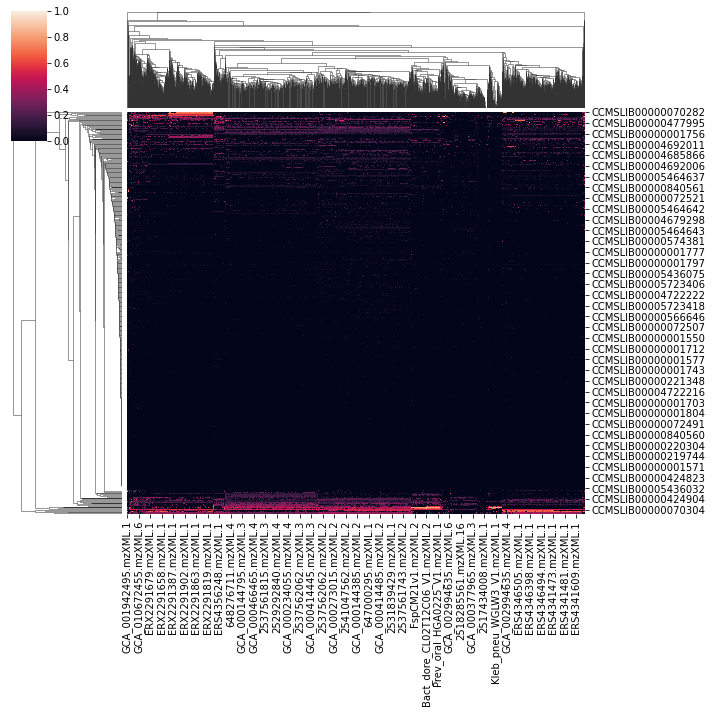

In [20]:
import seaborn as sns

sns.clustermap(ispec_mat)

In [21]:
strain_count = []

for item in ispec_mat.columns:
    strain = item.split('.')[0]
    if strain not in strain_count:
        strain_count.append(strain)
        
len(strain_count)

1571

## 2.4. Merging columns from same sample

In [22]:
ispec_mat_trans = ispec_mat.T
processed_list = []

merged_ispec_mat = pd.DataFrame()

for i,r in ispec_mat_trans.iterrows():
    strain = i.split('.')[0]
    if strain not in processed_list:
        print(i,strain)
        processed_list.append(strain)
        ispec_temp = ispec_mat_trans[ispec_mat_trans.index.map(lambda x: strain in x)]
        if len(ispec_temp) == 1:
            merged_ispec_mat[strain] = ispec_temp.loc[ispec_temp.index[0], :].values.tolist()
        else:
            merged_ispec_mat[strain] = list(ispec_temp.max(axis=0))

ERS4341365.mzXML.1 ERS4341365
GCA_000240165.mzXML.1 GCA_000240165
GCA_011290345.mzXML.1 GCA_011290345
GCA_000506385.mzXML.1 GCA_000506385
GCA_000012265.mzXML.1 GCA_000012265
GCA_003324555.mzXML.1 GCA_003324555
GCA_000012445.mzXML.1 GCA_000012445
GCA_001562525.mzXML.1 GCA_001562525
GCA_002899455.mzXML.1 GCA_002899455
GCA_003248315.mzXML.1 GCA_003248315
GCA_001625105.mzXML.1 GCA_001625105
GCA_000710405.mzXML.1 GCA_000710405
GCA_000413395.mzXML.1 GCA_000413395
GCA_000466545.mzXML.1 GCA_000466545
GCA_000466585.mzXML.1 GCA_000466585
GCA_000160635.mzXML.1 GCA_000160635
GCA_000214315.mzXML.1 GCA_000214315
GCA_000162155.mzXML.1 GCA_000162155
GCA_000162215.mzXML.1 GCA_000162215
GCA_000157015.mzXML.1 GCA_000157015
GCA_000273465.mzXML.1 GCA_000273465
GCA_000218325.mzXML.1 GCA_000218325
GCA_000159875.mzXML.1 GCA_000159875
GCA_000175315.mzXML.1 GCA_000175315
GCA_000185585.mzXML.1 GCA_000185585
GCA_000157075.mzXML.1 GCA_000157075
GCA_000159075.mzXML.1 GCA_000159075
GCA_000158335.mzXML.1 GCA_00015833

ERS4341482.mzXML.1 ERS4341482
ERS4341483.mzXML.1 ERS4341483
ERS4341484.mzXML.1 ERS4341484
ERS4341485.mzXML.1 ERS4341485
ERS4341486.mzXML.1 ERS4341486
ERS4341487.mzXML.1 ERS4341487
ERS4341488.mzXML.1 ERS4341488
ERS4341489.mzXML.1 ERS4341489
ERS4341490.mzXML.1 ERS4341490
ERS4341491.mzXML.1 ERS4341491
ERS4341492.mzXML.1 ERS4341492
ERS4341493.mzXML.1 ERS4341493
ERS4341494.mzXML.1 ERS4341494
ERS4341495.mzXML.1 ERS4341495
ERS4341496.mzXML.1 ERS4341496
ERS4341497.mzXML.1 ERS4341497
ERS4341498.mzXML.1 ERS4341498
ERS4341499.mzXML.1 ERS4341499
ERS4341500.mzXML.1 ERS4341500
ERS4341501.mzXML.1 ERS4341501
ERS4341502.mzXML.1 ERS4341502
ERS4341503.mzXML.1 ERS4341503
ERS4341504.mzXML.1 ERS4341504
ERS4341505.mzXML.1 ERS4341505
ERS4341507.mzXML.1 ERS4341507
ERS4341508.mzXML.1 ERS4341508
ERS4341509.mzXML.1 ERS4341509
ERS4341510.mzXML.1 ERS4341510
ERS4341511.mzXML.1 ERS4341511
ERS4341512.mzXML.1 ERS4341512
ERS4341513.mzXML.1 ERS4341513
ERS4341514.mzXML.1 ERS4341514
ERS4341515.mzXML.1 ERS4341515
ERS4341516

ERS4346528.mzXML.1 ERS4346528
ERS4346529.mzXML.1 ERS4346529
ERS4346530.mzXML.1 ERS4346530
ERS4346531.mzXML.1 ERS4346531
ERS4346532.mzXML.1 ERS4346532
ERS4346533.mzXML.1 ERS4346533
ERS4346534.mzXML.1 ERS4346534
ERS4346535.mzXML.1 ERS4346535
ERS4346536.mzXML.1 ERS4346536
ERS4346537.mzXML.1 ERS4346537
ERS4346538.mzXML.1 ERS4346538
ERS4346539.mzXML.1 ERS4346539
ERS4346540.mzXML.1 ERS4346540
ERS4346542.mzXML.1 ERS4346542
ERS4346543.mzXML.1 ERS4346543
ERS4346545.mzXML.1 ERS4346545
ERS4346546.mzXML.1 ERS4346546
ERS4346547.mzXML.1 ERS4346547
ERS4346549.mzXML.1 ERS4346549
ERS4346550.mzXML.1 ERS4346550
ERS4346551.mzXML.1 ERS4346551
ERS4346552.mzXML.1 ERS4346552
ERS4346553.mzXML.1 ERS4346553
ERS4346554.mzXML.1 ERS4346554
ERS4346555.mzXML.1 ERS4346555
ERS4346556.mzXML.1 ERS4346556
ERS4346557.mzXML.1 ERS4346557
ERS4346558.mzXML.1 ERS4346558
ERS4346559.mzXML.1 ERS4346559
ERS4346560.mzXML.1 ERS4346560
ERS4346561.mzXML.1 ERS4346561
ERS4346562.mzXML.1 ERS4346562
ERS4346563.mzXML.1 ERS4346563
ERS4346564

2531839307.mzXML.1 2531839307
2537561756.mzXML.1 2537561756
2537561665.mzXML.1 2537561665
2531839301.mzXML.1 2531839301
2547132079.mzXML.1 2547132079
2531839303.mzXML.1 2531839303
2534681605.mzXML.1 2534681605
2529293058.mzXML.1 2529293058
2534682202.mzXML.1 2534682202
2537561948.mzXML.1 2537561948
643886056.mzXML.1 643886056
2529293221.mzXML.1 2529293221
2529293225.mzXML.1 2529293225
2531839495.mzXML.1 2531839495
2541047014.mzXML.1 2541047014
2558860922.mzXML.1 2558860922
2600255042.mzXML.1 2600255042
2541047559.mzXML.1 2541047559
2541047560.mzXML.1 2541047560
2541047561.mzXML.1 2541047561
2541047562.mzXML.1 2541047562
2541047563.mzXML.1 2541047563
2541047564.mzXML.1 2541047564
2541047565.mzXML.1 2541047565
2541047566.mzXML.1 2541047566
2541047568.mzXML.1 2541047568
2541047569.mzXML.1 2541047569
2541047570.mzXML.1 2541047570
2541047572.mzXML.1 2541047572
2541047573.mzXML.1 2541047573
651324049.mzXML.1 651324049
2513237364.mzXML.1 2513237364
2513237359.mzXML.1 2513237359
651324085.mzXM

ERX2291761.mzXML.1 ERX2291761
ERX2291762.mzXML.1 ERX2291762
ERX2291616.mzXML.1 ERX2291616
ERX2291763.mzXML.1 ERX2291763
ERX2291764.mzXML.1 ERX2291764
ERX2291765.mzXML.1 ERX2291765
ERX2291766.mzXML.1 ERX2291766
ERX2291767.mzXML.1 ERX2291767
ERX2291768.mzXML.1 ERX2291768
ERX2291769.mzXML.1 ERX2291769
ERX2291770.mzXML.1 ERX2291770
ERX2291771.mzXML.1 ERX2291771
ERX2291617.mzXML.1 ERX2291617
ERX2291772.mzXML.1 ERX2291772
ERX2291299.mzXML.1 ERX2291299
ERX2291773.mzXML.1 ERX2291773
ERX2291774.mzXML.1 ERX2291774
ERX2291775.mzXML.1 ERX2291775
ERX2291776.mzXML.1 ERX2291776
ERX2291777.mzXML.1 ERX2291777
ERX2291778.mzXML.1 ERX2291778
ERX2291779.mzXML.1 ERX2291779
ERX2291780.mzXML.1 ERX2291780
ERX2291781.mzXML.1 ERX2291781
ERX2291618.mzXML.1 ERX2291618
ERX2291782.mzXML.1 ERX2291782
ERX2291783.mzXML.1 ERX2291783
ERX2291784.mzXML.1 ERX2291784
ERX2291785.mzXML.1 ERX2291785
ERX2291786.mzXML.1 ERX2291786
ERX2291787.mzXML.1 ERX2291787
ERX2291788.mzXML.1 ERX2291788
ERX2291789.mzXML.1 ERX2291789
ERX2291790

In [23]:
ispec_mat_trans[ispec_mat_trans.index.map(lambda x: 'GCA_000240165' in x)]

,CCMSLIB00000001675,CCMSLIB00005720216,CCMSLIB00000006873,CCMSLIB00000567505,CCMSLIB00000070259,CCMSLIB00000070265,CCMSLIB00005464639,CCMSLIB00000566828,CCMSLIB00004679300,CCMSLIB00004681487,...,CCMSLIB00000072480,CCMSLIB00000072494,CCMSLIB00000001693,CCMSLIB00000424800,CCMSLIB00000424828,CCMSLIB00000579285,CCMSLIB00000001650,CCMSLIB00000478602,CCMSLIB00000001644,CCMSLIB00005720233
GCA_000240165.mzXML.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.053056,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_000240165.mzXML.2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_000240165.mzXML.3,0.0,0.0,0.0,0.0,0.0,0.127718,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_000240165.mzXML.48,0.0,0.0,0.0,0.0,0.0,0.000000,0.053056,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_000240165.mzXML.49,0.0,0.0,0.0,0.0,0.0,0.127718,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCA_000240165.mzXML.50,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
merged_ispec_mat.index = list(ispec_mat.index)

merged_ispec_mat

,ERS4341365,GCA_000240165,GCA_011290345,GCA_000506385,GCA_000012265,GCA_003324555,GCA_000012445,GCA_001562525,GCA_002899455,GCA_003248315,...,GCA_010692445,GCA_010692465,GCA_010692525,GCA_010692535,GCA_010692555,GCA_010692575,GCA_010692585,GCA_010692635,GCA_010692645,GCA_010692685
CCMSLIB00000001675,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00005720216,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.303654,0.000000,0.0,0.417548,0.000000,0.0,0.0,0.190368,0.000000,0.192304
CCMSLIB00000006873,0.0,0.0,0.0,0.0,0.0,0.016627,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000567505,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000070259,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.906417,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCMSLIB00000579285,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000001650,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.093959,0.0,0.0,0.000000,0.000000,0.014037
CCMSLIB00000478602,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
CCMSLIB00000001644,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [25]:
len(merged_ispec_mat.columns)

1571

In [26]:
merged_ispec_mat.to_csv("./outputs/mass-affinity_df-NPOmix1.0-TFL210811.txt",sep="\t",index_label=False)

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


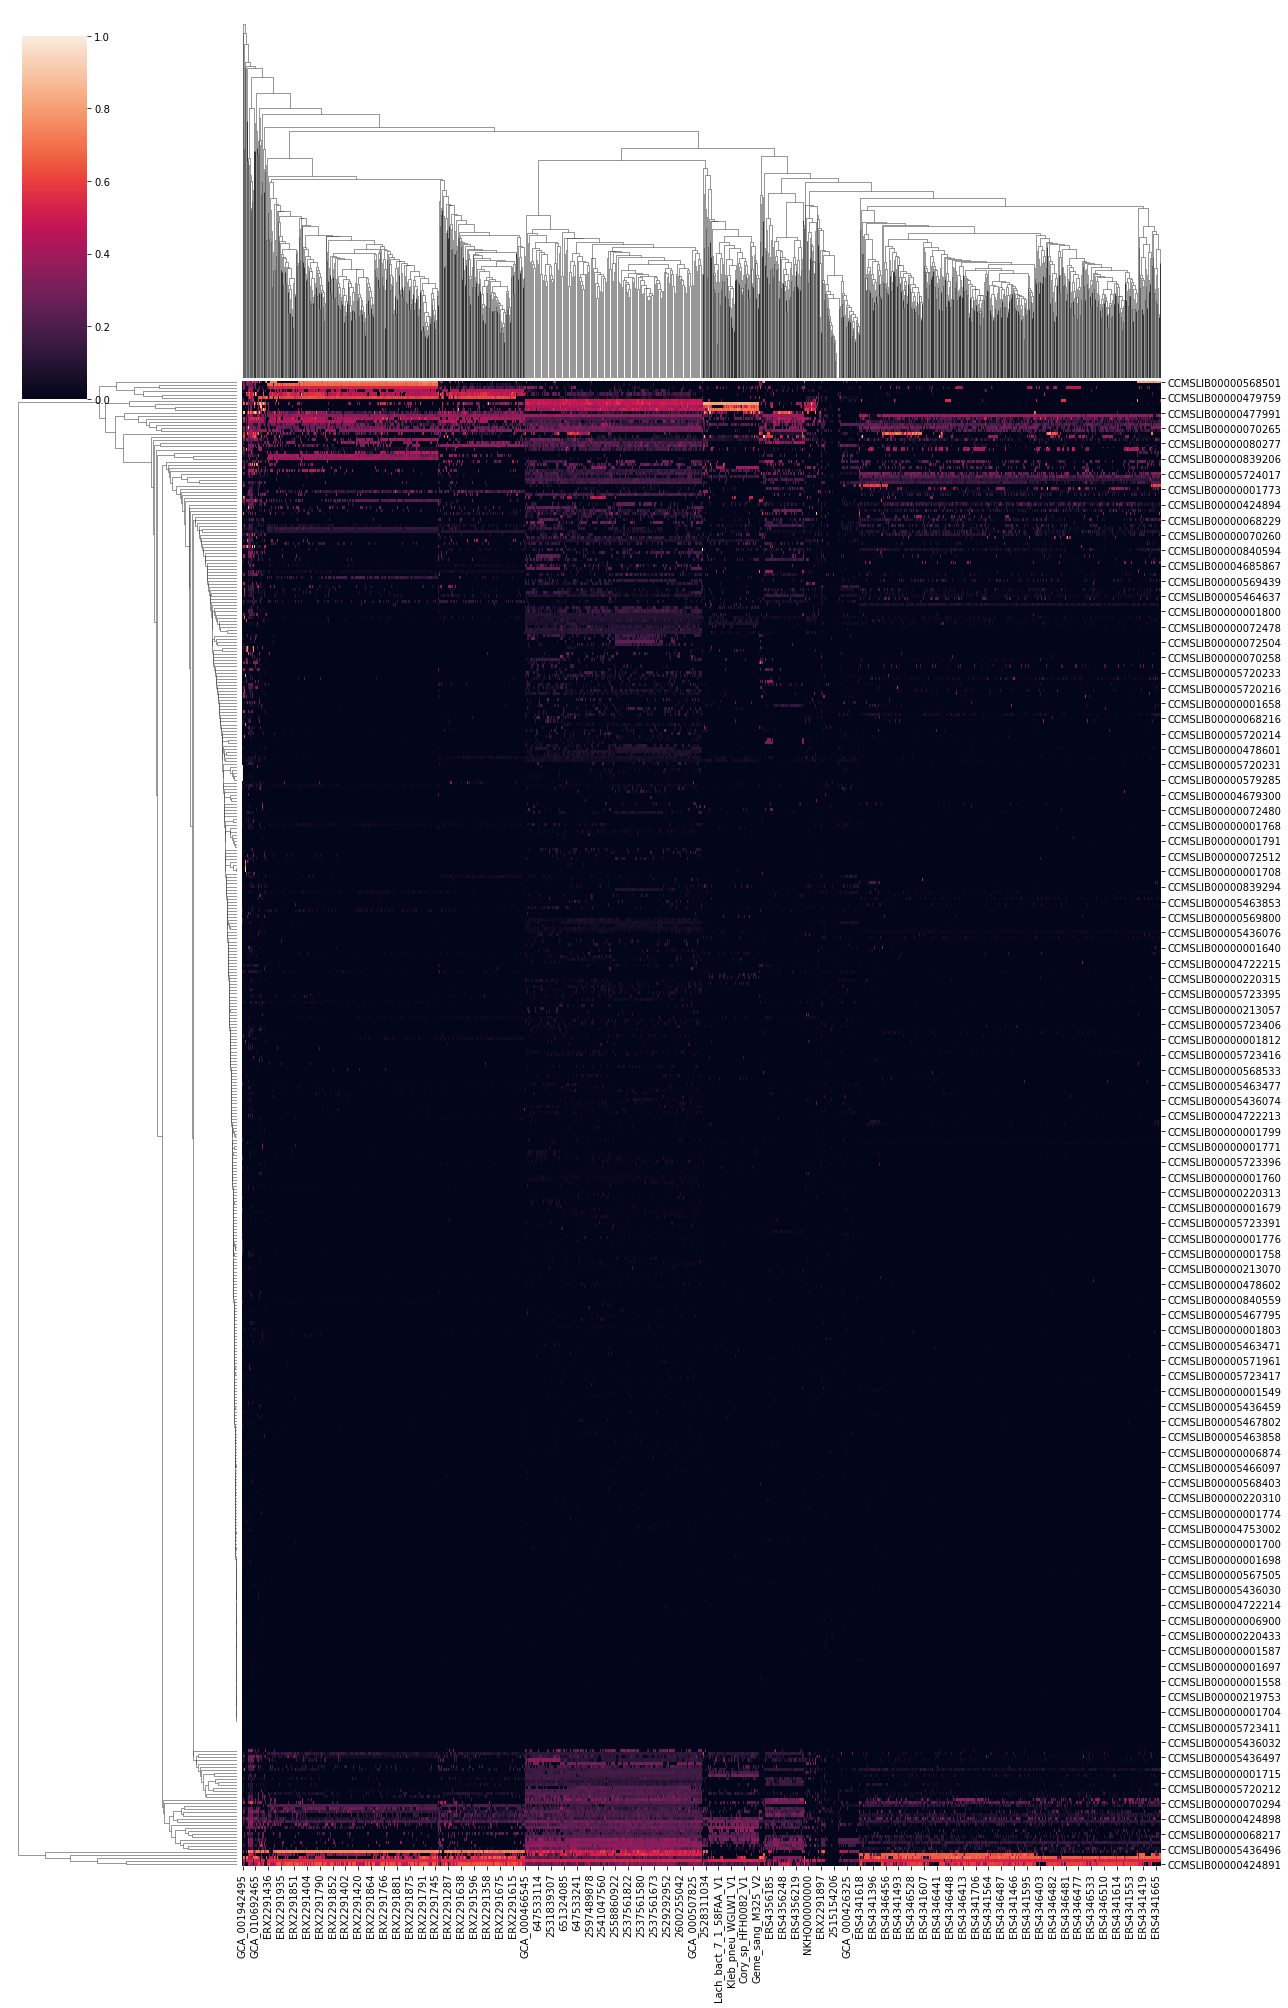

In [27]:
sns.clustermap(merged_ispec_mat,figsize=[18,28])